## The Solar Power Story in the Tracking the Sun dataset (LBNL)

### The growth of solar power

The news often tells us that the number of solar installations has grown dramatically.  The first question is: does the dataset support that claim?

The following graph gives us the answer.  This plot shows the number of solar installations per year for the years 1998 through 2016.

Note: the dataset is publicly available [here](https://openpv.nrel.gov/search).

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 8))
np.set_printoptions(precision=4, suppress=False)
# please show all columns
pd.set_option("display.max_columns", 60)
import seaborn as sns
sns.set()

In [3]:
# read in raw data
ttsRaw = pd.read_csv('../local/data/LBNL_openpv_tts_data/live_20180118',
                    parse_dates=['install_date'],
                    na_values=[-9999],
                    encoding = 'utf-8')

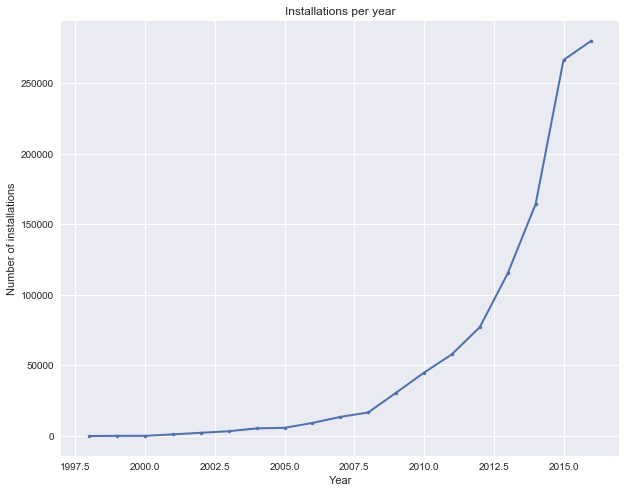

In [4]:
# show a picture
byYear = ttsRaw.groupby(lambda x: ttsRaw.loc[x, 'install_date'].year)
byYear.size().plot(marker='.', linewidth=2.0)
plt.xlim(1997, 2017)
plt.xlabel("Year")
plt.ylabel("Number of installations")
plt.title('Installations per year');

#### Interpretatation

While this dataset by no means describes every solar installation in the US (only 19 states are present in the data), all the largest state markets are included.

The growth shown in the graph above is exponential through 2015, with an average annual growth rate about 1.5.  In 2016, the data show that growth rate may be beginning to decline.  In any case, it's evident that US installations can be expected to continue to be in the hundreds of thousands for the near future as solar becomes more price competitive with traditional power sources.

### What is the behavior of cost/watt over time?

The cost of a solar power installation is generally measured in dollars per watt and calculated by dividing the total size of the installation in watts by the total cost in dollars.  As the media tell us, the price of solar power has decreased dramatically over the past few years.  Below we look at what the data says.

In [5]:
# read cleaned data
dftts = pd.read_csv('../local/data/LBNL_openpv_tts_data/ttsclean20180127.csv',
                    encoding='iso-8859-1', # avoids windows encoding issue
                    index_col='row_id',
                    parse_dates=['install_date'],
                    dtype={'zipcode' : np.object})

In [6]:
# capture the installation month for each row
month = dftts.install_date.apply(lambda x: x.to_period('M'))

In [7]:
# save in a new column
dftts = dftts.assign(install_month=month)

In [8]:
# group by customer type and installation month
byYeMoCust = dftts.groupby([dftts.cust_type, month])

In [9]:
# get median cost/watt for each customer type
medCPWbyCust = byYeMoCust.cost_per_watt.median()

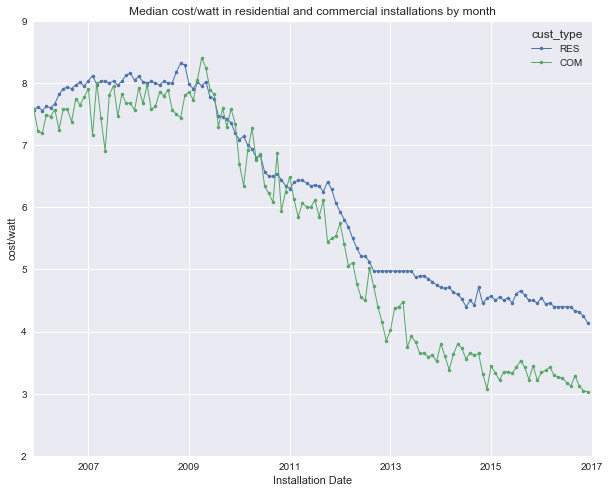

In [10]:
# unstack for plotting and limit to residential and commercial installations.
fig, ax = plt.subplots(figsize=(10, 8))
medCPWbyCust.unstack('cust_type')[['RES', 'COM']].plot(ax=ax, linewidth=1.0, marker='.')
ax.set_xlim(pd.datetime(2005, 12, 1), pd.datetime(2017, 1, 1))
ax.set_ylim(2, 9)
ax.set_title('Median cost/watt in residential and commercial installations by month')
ax.set_xlabel('Installation Date')
ax.set_ylabel('cost/watt');

#### Interpretation
The graph above shows that cost/watt has fallen dramatically over time.  From the beginning of 2007 to the end of 2016, the median cost/watt for residential customers has fallen from about \$8/watt to near \$4/watt.  Commercial customers have consistently paid less over this period showing a more pronounced reduction in price.

###   Does cost/watt vary by customer type

We see in the graph above that commercial customers pay less per watt of solar capacity.  Does that apply to the other customer types?  There are seven types of customer in the dataset.  Residential installations comprise 96% of the data.  Commercial installations are 2%.  The other five types represent only 2% of the data.  

In the graph below, we display the median cost/watt by month for all installation types.

In [11]:
# how many of each type of customer?
dftts.cust_type.value_counts()

RES           745688
COM            15199
NON-RES         7042
GOV             3996
NON-PROFIT      1951
SCHOOL          1748
TAX-EXEMPT        70
Name: cust_type, dtype: int64

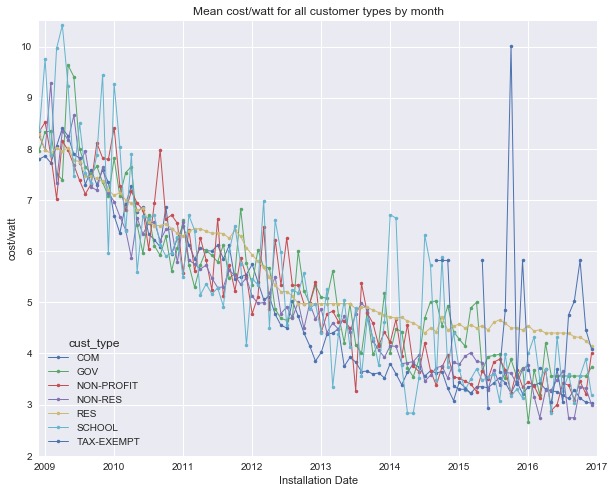

In [12]:
# unstack for plotting. show all customer types
fig, ax = plt.subplots(figsize=(10, 8))
medCPWbyCust.unstack('cust_type').plot(ax=ax, linewidth=1.0, marker='.')
ax.set_xlim(pd.datetime(2008, 12, 1), pd.datetime(2017, 1, 1))
ax.set_ylim(2, 10.5)
ax.set_title('Mean cost/watt for all customer types by month')
ax.set_xlabel('Installation Date')
ax.set_ylabel('cost/watt');

### Interpretation
One thing to keep in mind while considering the graph above: the number of nonresidential installations is quite small compared to the residential installations (30k vs. 750k).  Further those 30k nonresidential installations are split among 6 types, the largest of which is commercial (business) installations. The smaller customer types show much more variability than the larger groups.  This explains the peaks seen above.

This graph shows that residential customers generally pay more at any given time than non-residential customers.  One possible explanation for this difference is that nonresidential customers typically buy larger installations and therefore get more favorable pricing.  We examine the relationship between cost/watt and size of installation below.

### Does cost/watt decrease with the size of the installation and does this vary over time?

We see above that residential installations tend to have a higher cost/watt than all other types.  The output below shows that
residential installations median size is 5.75kw, while commercial installations are generally larger with a median of 27.72kw.

It is reasonable to expect that commercial installations have less expensive per watt costs due to quantity discounts.  We examine this assumption below.

In [13]:
# compare summary statistics for size(kw) between residential and commercial installations.
dfSizeDesc = pd.DataFrame({ 'res size(kw)'  :   dftts[dftts.cust_type == 'RES'].size_kw.describe(),
                            'com size(kw)'  :   dftts[dftts.cust_type == 'COM'].size_kw.describe() })
dfSizeDesc

,com size(kw),res size(kw)
count,15199.000000,745688.000000
mean,131.308669,6.457227
std,373.813536,7.099405
min,0.330000,0.108000
25%,10.000000,4.025560
50%,25.200000,5.750000
75%,80.640000,7.955000
max,5998.740000,1989.520000


In [14]:
# compare summary statistics for cost/watt between residential and commercial installations.
dfCostDesc = pd.DataFrame({'res cost/watt'  :   dftts[dftts.cust_type == 'RES'].cost_per_watt.describe(),
                           'com cost/watt'  :   dftts[dftts.cust_type == 'COM'].cost_per_watt.describe() })
dfCostDesc

,com cost/watt,res cost/watt
count,15199.000000,745688.000000
mean,5.212474,5.144334
std,2.439686,1.846271
min,1.001380,1.000000
25%,3.308127,4.040000
50%,4.731034,4.941176
75%,6.931158,5.787037
max,19.638117,20.000000


__ In order to see if cost/watt varies with size, it is important to compare installations where only the size differs so we restrict the set to residential installations.  Residential installations comprise 96% of the data.  We begin by looking at the distribution of sizes.__

0.999015674116


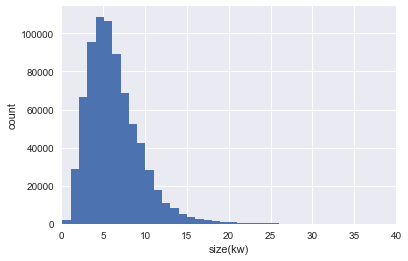

In [15]:
# What is the distribution of size(kw) for residential installations?
# almost all are less than 37kw
dfRes = dftts[dftts.cust_type == 'RES']
fig, ax = plt.subplots(figsize=(6,4))
plt.hist(dfRes.size_kw, bins=2000)
plt.xlim(0,40);
ax.set_xlabel('size(kw)')
ax.set_ylabel('count');

print(dfRes[dfRes.size_kw < 40].size/dfRes.size)

In [16]:
# create a scaling vector to map sizes to integers
scaledSize = dfRes.size_kw/2.5 
# map to integer
scaledSize = scaledSize.astype(np.int)
# put everything over 25kw into the top bin
scaledSize = scaledSize.map(lambda x: 10 if x > 10 else x)

In [17]:
# store the scaled size with the data
dfRes = dfRes.assign(scaledSize=scaledSize)

In [18]:
# group by scaledSize and installation month
bySizeMo = dfRes.groupby([dfRes.scaledSize, dfRes.install_month])

__ The graph below shows that in general, the smallest installations pay the highest cost/watt, while the largest sizes pay substantially less.  We'll visualize this further below. __

In [19]:
# different strokes for different sizes
styler = {0:'b-^', 1:'g-^', 2:'r-^', 3:'c-^',
          4 : 'm-^', 5 :  'k-^', 6 :  'b:v', 7 : 'g:v',
          8:'r:v', 9:'c:v', 10:'m:v', 11:'k:v',
          12 : 'b', 13 : 'g', 14 : 'r', 15 : 'c', 16 : 'm',
          17 : 'k', 18 : 'b'}

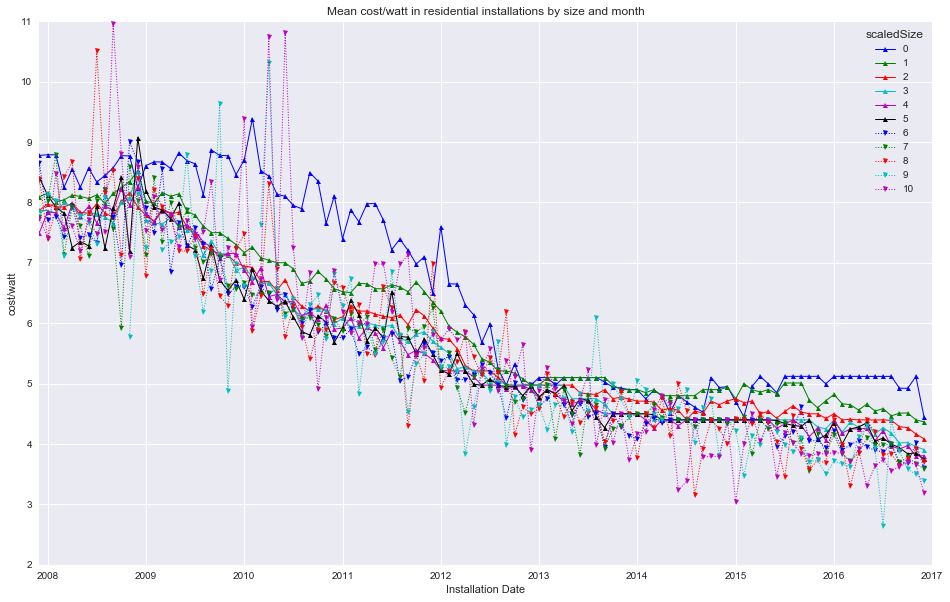

In [20]:
# plot cost/size against time.
fig, ax = plt.subplots(figsize=(16, 10))
bySizeMo.cost_per_watt.median().unstack('scaledSize').plot(ax=ax, linewidth=1.0, style=styler, markersize=5)

ax.set_xlim(pd.datetime(2007, 12, 1), pd.datetime(2017, 1, 1))
ax.set_ylim(2, 11)
ax.set_title('Mean cost/watt in residential installations by size and month')
ax.set_xlabel('Installation Date')
ax.set_ylabel('cost/watt');

__ The plot above shows cost/watt declining as time increases and as size increases.__

In [21]:
# set up for 3D plot
theData = bySizeMo.cost_per_watt.median().unstack('scaledSize')

In [22]:
# check the data; not all size/mon pairs are populated, especially early on
theData.head()

scaledSize,0,1,2,3,4,5,6,7,8,9,10
install_month,,,,,,,,,,,
1998-01,10.921508,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-02,8.667013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-04,13.962563,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-07,NaN,6.858942,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-08,6.768190,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


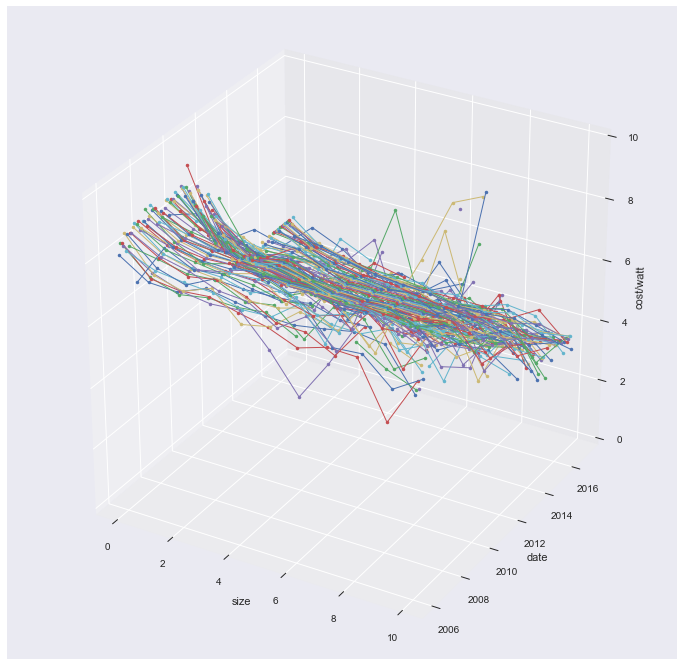

In [23]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')

# y is the date
# x is size factor (bigger is larger)
# z is the cost per watt
# we plot each row (223) at a time

# the counter is the row number
for i in range(90, len(theData)):
    if i % 1 == 0:
        xx = np.arange(0,11)
        theYeMo = theData.index[i]
        yy = np.ones(11) * (theYeMo.year + theYeMo.month/12)
        zz=theData.iloc[i]
        ax.plot(xx, yy, zz, marker='.', linewidth=1)

ax.set_xlabel('size')
ax.set_ylabel('date')
ax.set_zlabel('cost/watt')
ax.set_zlim(0, 10);

__ The plot above is pseudo-surface showing the same data in the previous 2-d graph. __

In [24]:
# set up for surface plot
theYeMo = theData.index.map(lambda x: x.year + x.month/12)
theDataSaved = theData
# theData = theDataSaved

In [25]:
# fill in the NaNs
theData = theData.fillna(method='bfill')

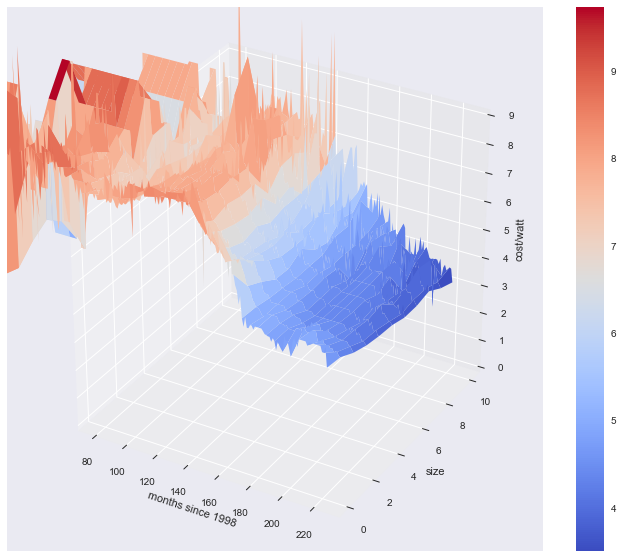

In [26]:
# surface plot of cost(z) against time(x) and size group(y)
from matplotlib import cm
fig = plt.figure(figsize=(12,10))
ax = fig.gca(projection='3d')

# set up the size * time plane
X, Y = np.meshgrid(np.arange(223), np.arange(11))

surf = ax.plot_surface(X, Y, theData.values.T, cmap=cm.coolwarm,
                       linewidth=1, antialiased=True)
#                      vmin=np.nanmin(Z), vmax=np.nanmax(Z) )
#                                         vmin=2, vmax=10 )
cbar = plt.colorbar(surf)
ax.set_xlim(72,)
ax.set_xlabel('months since 1998')
ax.set_ylabel('size')
ax.set_zlabel('cost/watt')
ax.set_zlim(0, 9);

#### Interpretation

The three graphs above all show the same data, depicted in three different ways.  In each, the size of the installation binned into 2.5kw-wide bins (i.e. 0-2.5kw, 2.5-5kw,etc).  Anything larger than 25kw is pushed into the bin representing the largest installations.

The first graph is perhaps the clearest in that the groups are visually separable and it is quite apparent that within most month-long periods, the smallest installations pay the highest price, with price decreasing as size increases.  

The second two graphs add visual intuition about the shape of the surface of cost/watt as a function of both time and size, showing a surface with generally negative slope as both time and size increase.  The 'cliffs' in the surface plot are due to filling in missing data in the size-group space.  In the earlier data, few size groups are populated as the number of installations is smaller.  At later dates, as the number of installations increases, all size groups are represented and the surface becomes better behaved.

From smallest to largest, all groups show decrease in cost over time.  The decrease in price as size increases while time is held constant is not as steep.

### Does cost/watt vary by region?

It's natural to ask if the cost of solar power varies by location.  The graph below says that historically, location has had a significant impact on the market price of solar installations.

In [27]:
# look at residential installs; group by state, installation year and month
# already there dfRes = dftts[dftts.cust_type == 'RES']
resByStYeMo = dfRes.groupby([dfRes.state, dftts.install_month])

In [28]:
resMedianCPWBySt = resByStYeMo.cost_per_watt.median().unstack('state')

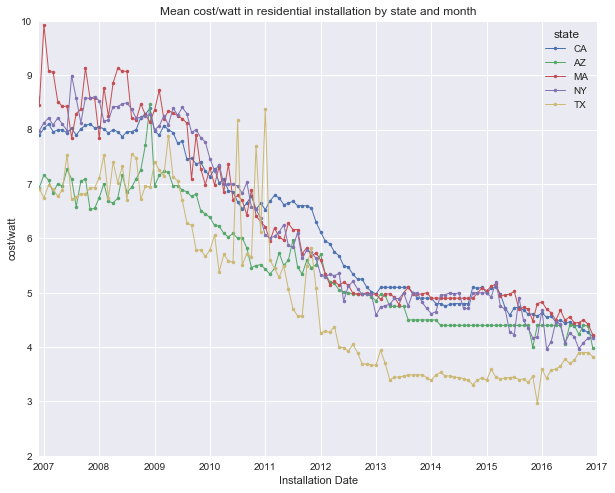

In [29]:
fig, ax = plt.subplots(figsize=(10, 8))
resMedianCPWBySt[['CA', 'AZ', 'MA', 'NY', 'TX']].plot(ax=ax, linewidth=1.0, marker='.')
ax.set_xlim(pd.datetime(2006, 12, 1), pd.datetime(2017, 1, 1))
ax.set_ylim(2, 10)
ax.set_title('Mean cost/watt in residential installation by state and month')
ax.set_xlabel('Installation Date')
ax.set_ylabel('cost/watt');

#### Interpretation

The differences in market price for solar installations can perhaps be explained by 'cost of doing business'.  Texas is consistently the least expensive state.  California where higher costs are offset by strong incentives is by far the largest market.  For clarity not all states are show in the image.

The graph above has two interesting features:
1.  Historically the cost of solar power has varied widely from state to state. For example, in 2014, the median cost/watt in New York was over \$5/watt, while in Texas the median cost was about \$3.50.  In earlier year, prices diverged by even greater amounts.
2.  Over time, the differential by state seems to be diminishing at the same time as costs decrease in almost every state.

### What is the impact of True/False features on cost/watt?

The following features are boolean variables in the dataset. There are two different kinds of features: those having to do with price characteristics and those associated with hardware in the installation.

* third_party -  is the installation is owned by a third party?  
* appraised_value - is the cost/watt a market price or an appraised price?
* new_const - is the installation part of the initial construction of the residence?

These features describe how the price in the dataset can be intepreted.  *Third-party* installations are owned by the vendor (i.e. neither the consumer or utility) and typically installed at no upfront coat to the consumer.  The installation is funded by the owner of the system in conjunction with a long-term power purchase contract with the consumer.  An *appraised* price is not as trustworthy as a market price because it is possible to manipulate.  There are possible motives to report an inflated or reduced cost appealing to various parties (installers, consumer, system owner, incentive program participants). *New construction* may provide an opportunity to save on installation costs.

The features below also take the form of boolean variables but represent physical aspects of the installation.

* ground_mounted
* battery
* tracking
* uinverter (microinverter)
* dc_optimizer

*Ground mounted* systems may be better located with respect to the amount of sun and may offer a simpler (and less expensive) installation.  *Battery* equipped systems store power for use at night but are more costly.  *Tracking* systems incorporate machinery to aim the solar array for higher power production but are more costly.  *Microinverter* systems  are simpler to install and configure but cost more in aggregate than a single large inverter.  *DC optimizers* provide advantages in flexibilty of system design and management at additional hardware cost.

#### Appraised cost/watt vs. market price

In [30]:
# how many appraised prices are there?
dftts.appraised_value.value_counts()

False    547038
True     228656
Name: appraised_value, dtype: int64

In [31]:
byYeMoAppraised = dftts.groupby([dftts.appraised_value, month])

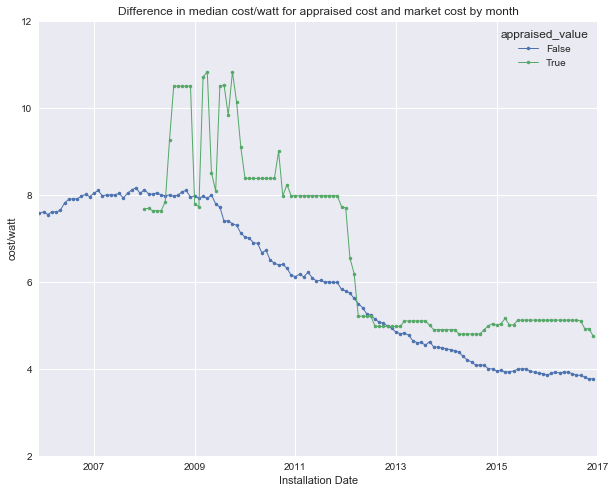

In [32]:
# unstack for plotting
fig, ax = plt.subplots(figsize=(10, 8))
byYeMoAppraised.cost_per_watt.median().unstack('appraised_value').plot(ax=ax, linewidth=1.0, marker='.')
ax.set_xlim(pd.datetime(2005, 12, 1), pd.datetime(2017, 1, 1))
ax.set_ylim(2, 12)
ax.set_title('Difference in median cost/watt for appraised cost and market cost by month')
ax.set_xlabel('Installation Date')
ax.set_ylabel('cost/watt');

#### Interpretation

It is clear from the data that appraised prices tend to exceed market prices for solar installations.  One implication for an analysis is that since there are so many (approximately 230k) it may be worth excluding appraised prices from a model training set.

#### Third-party ownership

In [33]:
# how many third-party systems?
dftts['third-party'].value_counts()

False    431039
True     344655
Name: third-party, dtype: int64

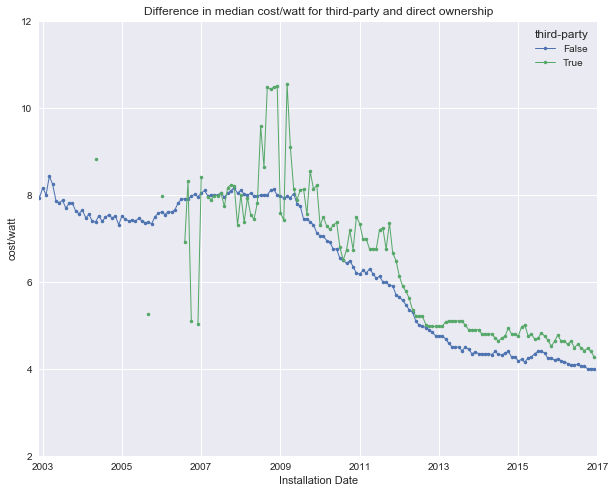

In [34]:
# third_party
byYeMoTP = dftts.groupby([dftts['third-party'], dftts.install_month])
fig, ax = plt.subplots(figsize=(10, 8))
byYeMoTP.cost_per_watt.median().unstack('third-party').plot(ax=ax, linewidth=1.0, marker='.')
ax.set_xlim(pd.datetime(2002, 12, 1), pd.datetime(2017, 1, 1))
ax.set_ylim(2, 12)
ax.set_title('Difference in median cost/watt for third-party and direct ownership')
ax.set_xlabel('Installation Date')
ax.set_ylabel('cost/watt');

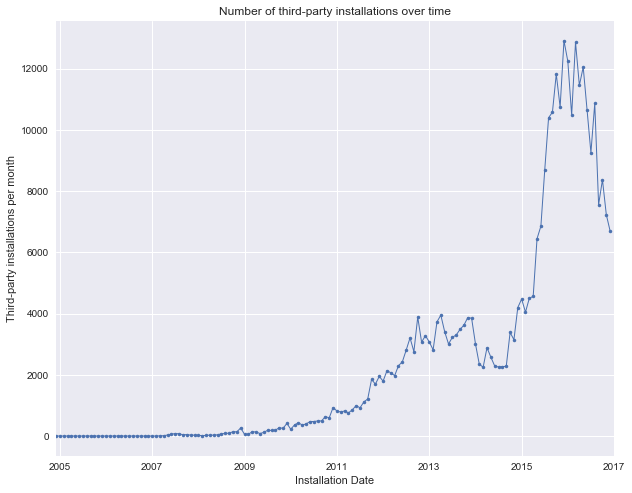

In [35]:
# third_party counts vs. time
plt.clf()
fig, ax = plt.subplots(figsize=(10, 8))
byYeMo = dftts.groupby('install_month')
byYeMo['third-party'].sum().plot(ax=ax, linewidth=1, marker='.')
ax.set_xlim(pd.datetime(2004, 12, 1), pd.datetime(2017, 1, 1))
ax.set_ylim()
ax.set_title('Number of third-party installations over time')
ax.set_xlabel('Installation Date')
ax.set_ylabel('Third-party installations per month');

#### Interpretation

It's interesting to see that in the 2006-2007 time frame, third-party ownership becomes popular as a result of tax incentives and the wide availabilty of credit to third-party owners.

There seems to be a consistent trend for third-party pricing to exceed direct ownership pricing though the difference tends to be less in recent years.

There are many reasons for the differential (e.g. price may be inflated since third-party owner often controls the supply chain and installation process).  We will not examine this in detail in this project.

It should be noted that third-party owned systems comprised a very substantial subset.  For accurate analysis of market price it may be necessary to exclude these from cost/watt modeling.


#### New construction

In [36]:
# how many are new construction ~30k
dftts.new_const.value_counts()

False    745951
True      29743
Name: new_const, dtype: int64

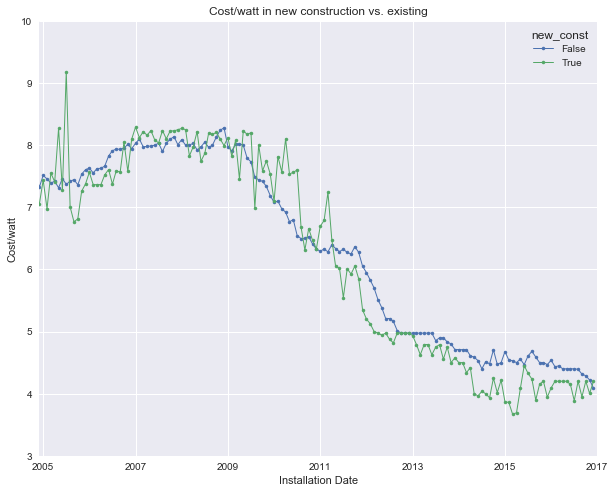

In [37]:
# new construction
byYeMoNewCon = dftts.groupby([dftts.new_const, dftts.install_month])
fig, ax = plt.subplots(figsize=(10, 8))
byYeMoNewCon.cost_per_watt.median().unstack('new_const').plot(ax=ax, linewidth=1, marker='.')

ax.set_xlim(pd.datetime(2004, 12, 1), pd.datetime(2017, 1, 1))
ax.set_ylim(3,10)
ax.set_title('Cost/watt in new construction vs. existing')
ax.set_xlabel('Installation Date')
ax.set_ylabel('Cost/watt');

#### Interpretation
In recent years, cost/watt pricing in new construction seems to enjoy at least a slight advantage.  The data only contain about 30k such installations.

#### tracking

In [38]:
# how many systems with tracking? ~3k
dftts.tracking.value_counts()

False    772532
True       3162
Name: tracking, dtype: int64

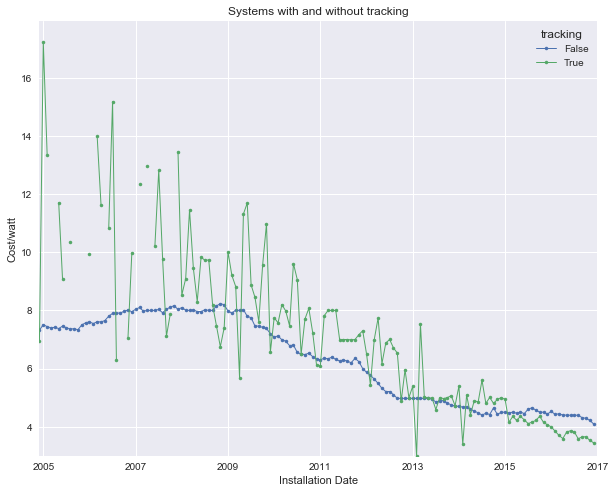

In [39]:
# tracking
byYeMoTrack = dftts.groupby([dftts['tracking'], dftts.install_month])
fig, ax = plt.subplots(figsize=(10, 8))
byYeMoTrack.cost_per_watt.median().unstack('tracking').plot(ax=ax, linewidth=1, marker='.')
ax.set_xlim(pd.datetime(2004, 12, 1), pd.datetime(2017, 1, 1))
ax.set_ylim(3,)
ax.set_title('Systems with and without tracking')
ax.set_xlabel('Installation Date')
ax.set_ylabel('Cost/watt');

In [40]:
# Are tracking systems usually ground mounted?  Yes, they are.
dftts[(dftts.tracking == True) & (dftts.ground_mounted == True)].shape

(2819, 23)

#### Interpretation
There are only about 3k systems with tracking in the data.  The graph above looks very similar to the one immediately below because most tracking systems are ground mounted.  As a result the pricing is tightly coupled with ground mount systems.

The graph above suggests that prior to 2015 tracking systems were quite expensive compared to those without tracking.  It may be that tracking technology has matured by 2015 and that prices reflect deployment of off-the-shelf technology as opposed to custom systems.

#### ground_mounted systems

In [41]:
# how many are ground mounted? ~12k
dftts.ground_mounted.value_counts()

False    763352
True      12342
Name: ground_mounted, dtype: int64

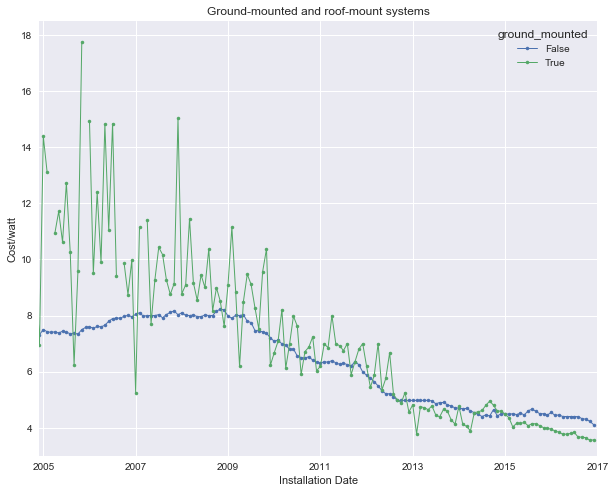

In [42]:
#### ground_mounted systems
byYeMoGround = dftts.groupby([dftts['ground_mounted'], dftts.install_month])
fig, ax = plt.subplots(figsize=(10, 8))
byYeMoGround.cost_per_watt.median().unstack('ground_mounted').plot(ax=ax, linewidth=1, marker='.')
ax.set_xlim(pd.datetime(2004, 12, 1), pd.datetime(2017, 1, 1))
ax.set_ylim(3,)
ax.set_title('Ground-mounted and roof-mount systems')
ax.set_xlabel('Installation Date')
ax.set_ylabel('Cost/watt');

#### interpretation

There are around 12k ground-mounted systems in the data.  The pricing trends are similar to tracking systems in that in later years, we see that the premium for ground-mounting declines and may actually be advantageous compared to roof mounting.

#### battery

In [43]:
# how many have batteries? Almost none
dftts.battery.value_counts()

False    775535
True        159
Name: battery, dtype: int64

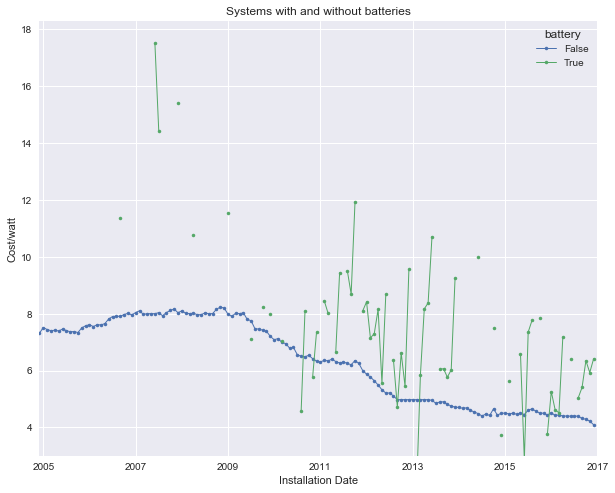

In [44]:
# battery
byYeMoBatt = dftts.groupby([dftts['battery'], dftts.install_month])
fig, ax = plt.subplots(figsize=(10, 8))
byYeMoBatt.cost_per_watt.median().unstack('battery').plot(ax=ax, linewidth=1, marker='.')
ax.set_xlim(pd.datetime(2004, 12, 1), pd.datetime(2017, 1, 1))
ax.set_ylim(3,)
ax.set_title('Systems with and without batteries')
ax.set_xlabel('Installation Date')
ax.set_ylabel('Cost/watt');

#### interpretation

We have almost no data for battery-equipped solar installations (159 units).  If the graph above can be believed with so little data, batteries greatly increased the cost of solar installation through the end of 2016.  Recent techological and manufacturing developments promise substantial savings in battery cost, making this one of the most interesting areas in the near future.

#### uinverter (microinverter)

In [45]:
# how many microinverters?  160k
dftts.uinverter.value_counts()

False    616685
True     159009
Name: uinverter, dtype: int64

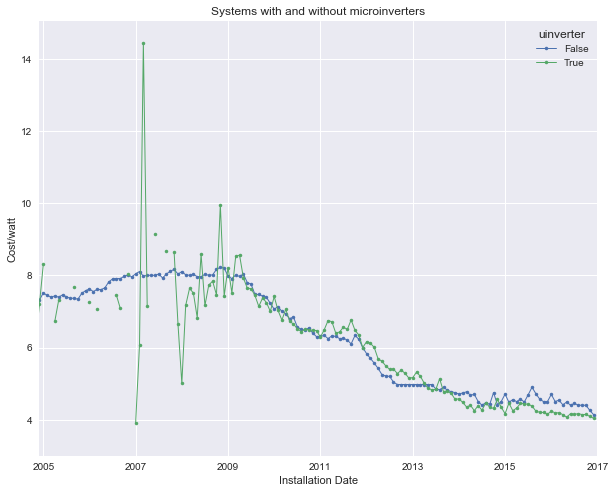

In [46]:
# micro-inverter
byYeMoUInv = dftts.groupby([dftts['uinverter'], dftts.install_month])

fig, ax = plt.subplots(figsize=(10, 8))
byYeMoUInv.cost_per_watt.median().unstack('uinverter').plot(ax=ax, linewidth=1, marker='.')
ax.set_xlim(pd.datetime(2004, 12, 1), pd.datetime(2017, 1, 1))
ax.set_ylim(3,)
ax.set_title('Systems with and without microinverters')
ax.set_xlabel('Installation Date')
ax.set_ylabel('Cost/watt');

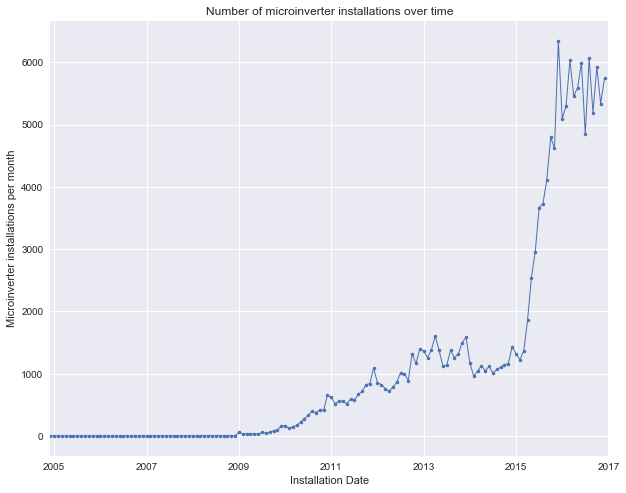

In [47]:
# microinverter deployments vs. time
plt.clf()
fig, ax = plt.subplots(figsize=(10, 8))
byYeMo['uinverter'].sum().plot(ax=ax, linewidth=1, marker='.')
ax.set_xlim(pd.datetime(2004, 12, 1), pd.datetime(2017, 1, 1))
ax.set_ylim()
ax.set_title('Number of microinverter installations over time')
ax.set_xlabel('Installation Date')
ax.set_ylabel('Microinverter installations per month');

#### interpretation

The graphs above show a true success story.  Micro-inverters convert DC to AC on a per solar panel basis.  The cost of the set of microinverters is larger than a single inverter for a system of the same size.  But microinverters allow a simplified design process for the solar array.  Avoiding an involved design allows installers to configure much more quickly by using less of a scarce resource (design talent).  The upshot is that microinverter systems have achieved (or surpassed) pricing parity with traditional systems by 2015.

#### dc_optimizer

In [48]:
# how many dc_optimizers
dftts.dc_optimizer.value_counts()

False    654080
True     121614
Name: dc_optimizer, dtype: int64

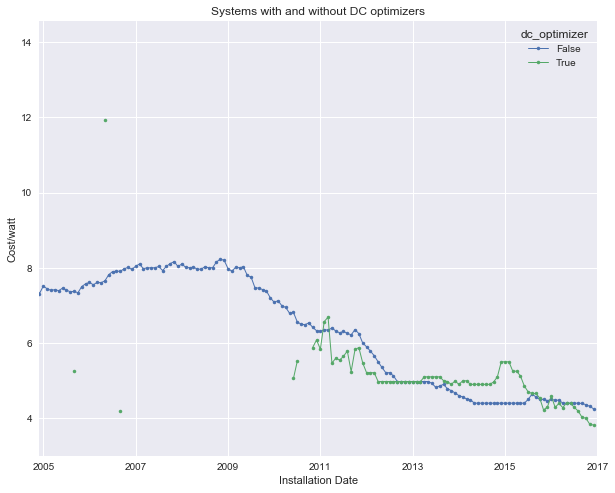

In [49]:
# dc_optimizer
byYeMoDCO = dftts.groupby([dftts['dc_optimizer'], dftts.install_month])

fig, ax = plt.subplots(figsize=(10, 8))
byYeMoDCO.cost_per_watt.median().unstack('dc_optimizer').plot(ax=ax, linewidth=1, marker='.')
ax.set_xlim(pd.datetime(2004, 12, 1), pd.datetime(2017, 1, 1))
ax.set_ylim(3,)
ax.set_title('Systems with and without DC optimizers')
ax.set_xlabel('Installation Date')
ax.set_ylabel('Cost/watt');

#### interpretation

DC optimizers play a similar role to microinverters in that they simplify the design process facilitating rapid deployment of solar arrays, with a different technical approach.  In the near future, modules with the combined functionality of microinverters and DC optimzers are expected to supplant both.